<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/07/PTE_DL7_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN finomhangolás

Az ImageNet adathalmaz több mint 1 millió gyakorló képből áll.

**Mi van, ha nincs túl sok képünk?**
 1. menjünk és gyűjtsünk sokkal több adatot
 2. használjuk az ImageNet adathalmazból tanult tudást

Az 1 millió ImageNet-képen betanított neurális hálózat használatával **jó belső reprezentációval** kell rendelkeznie (kerek tárgyak, szemek, szöveg stb. megtalálása) a különböző tárgyak fotóihoz. A transzfer tanulás lényege, hogy ezekre a reprezentációkra támaszkodunk.

Általánosságban a transzfer tanulás során azt szeretnénk, hogy minél több információ kerüljön át az egyik adatkészletből a másikba. Mivel az első rétegek általánosak, nem kell sokat változniuk, így jóval alacsonyabb tanulási sebesség is megfelel. Az utolsó rétegek feladatspecifikusabbak, így ezeket jobban kell képeznünk (magasabb tanulási rátával).


In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Kutyák és macskák

A Kaggle "Kutyák és macskák" verseny adatait fogjuk használni. A dolgok megnehezítése érdekében a gyakorló képek egy apró részhalmazára korlátozódunk, 300 képre a kutyák és 300 képre a macskák esetében.

<img src="https://storage.googleapis.com/kaggle-media/competitions/kaggle/3362/media/woof_meow.jpg">

https://www.kaggle.com/c/dogs-vs-cats/

Az ImageNet előre betanított modelljei tökéletes választásnak tűnnek, mivel az ImageNet több mint 100 különböző kutyafajtát tartalmaz, így a hálózat súlyainak kivételesnek kell lenniük a kutyák osztályozásakor.



In [ ]:
# download the prepared dataset
!gdown --id 1Gj4T1NIThIx_Py4hd2YbAGpVJhpUlCVK

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Gj4T1NIThIx_Py4hd2YbAGpVJhpUlCVK
From (redirected): https://drive.google.com/uc?id=1Gj4T1NIThIx_Py4hd2YbAGpVJhpUlCVK&confirm=t&uuid=6225ec7a-ca0c-4e8a-92c4-8f028b038d1e
To: /content/dogscats.zip
100% 572M/572M [00:09<00:00, 58.3MB/s]


In [ ]:
# unzip it
!unzip -q dogscats.zip

In [ ]:
train_dogs = list(Path('train/dog/').glob('*'))
train_cats = list(Path('train/cat/').glob('*'))

print(f'#Training images: {len(train_cats), len(train_dogs)}')

test_dogs = list(Path('test/dog/').glob('*'))
test_cats = list(Path('test/cat/').glob('*'))

print(f'#Test images: {len(test_cats), len(test_dogs)}')

#Training images: (300, 300)
#Test images: (12200, 12200)


### A képek többsége korrekt, de néhány kép problémás lehet!

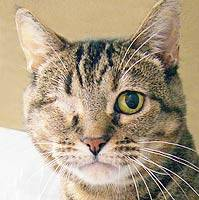

In [ ]:
Image.open('train/cat/cat.11368.jpg')

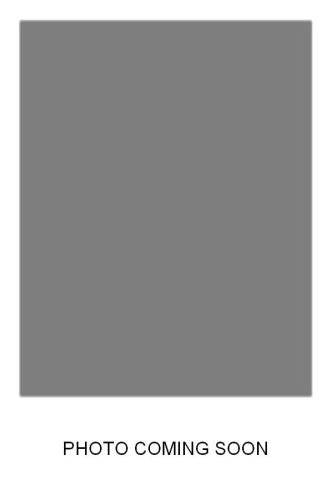

In [ ]:
Image.open('train/cat/cat.11184.jpg')

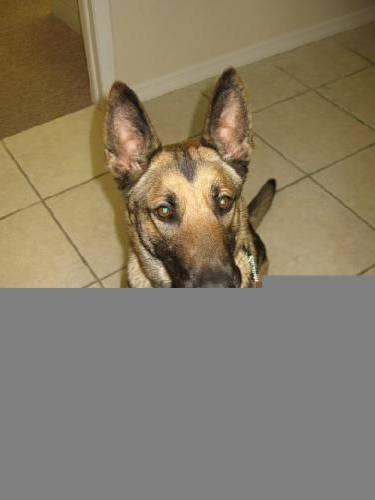

In [ ]:
Image.open('train/dog/dog.11191.jpg')

### Modell létrehozása

A ResNet50-et fogjuk használni, két modellt készítünk:

 1. véletlenszerűen inicializált
 2. előre képzett imagenet-en

Mivel az ImageNet 1000 kategóriát tartalmaz, az utolsó réteget úgy kell módosítanunk, hogy 1000 helyett 1 neuron legyen. Egy bináris osztályozót fogunk betanítani (0-1), hogy jelezze, hogy macska vagy kutya van-e a képen.

 - bináris keresztentrópia
 - sigmoid a softmax helyett
   - softmax egy neuronnal $\to$ konstans 1 előrejelzés mindig
   A modellek beállítása
Használhattunk volna 2 neuront is kategorikus crossentrópiával és softmax-szal.

In [ ]:
# we could set classes=1, but the default activation is softmax
# softmax with one neuron is not the best idea...
#basemodel = tf.keras.applications.ResNet50(weights=None, include_top=False)
base_model = ResNet50(weights=None, include_top=False)
base_pretrained_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

Az utolsó réteg eltávolítása és egy új modell létrehozása, amelynek a végén 1 neuron van szigmoid aktiválással.

In [ ]:
x = base_pretrained_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
pretrained_model = Model(inputs=base_pretrained_model.input, outputs=predictions)

Az előre betanított modell esetében az utolsó réteg kivételével az összes réteget befagyasztjuk.

In [ ]:

for i in pretrained_model.layers[:-1]:
    i.trainable = False

Nézzük meg mindkét modellt!

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 25,685,888 (97.98 MB)

## Dataloader

Korábban csak betöltöttük az összes adatot a memóriába, és adtuk át a neurális hálózatnak. Nagyobb datset esetén gyakran előfordul, hogy egyszerűen nem fér el a RAM-ban. A datagenerátorok olyan függvények, amelyek egyszerre egy adag adatot szolgáltatnak.

A Tf-keras rendelkezik egy beépített ImageDataGeneratorral, itt ezt fogjuk használni. A képnövelés a dataloader-en belül is elvégezhető.

A kategóriákat a mappanevekből illesztjük össze.

In [ ]:
def imagenet_convert(img):
    img  = img.astype(float)[...,::-1] # RGB --> BGR
    img -= [103.939, 116.779, 123.68]
    return img

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function=imagenet_convert)

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator( rescale = 1.0/255. , preprocessing_function=imagenet_convert )


In [ ]:
train_datagenerator = ImageDataGenerator(preprocessing_function=imagenet_convert)
test_datagenerator  = ImageDataGenerator(preprocessing_function=imagenet_convert)

train_datagenerator = train_datagenerator.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

test_datagenerator = test_datagenerator.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 24400 images belonging to 2 classes.


Állítsuk össze a modelleket az Adam optimalizálóval $10^{-4}$ tanulási rátával.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
pretrained_model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

### A modelleket 25 korszakon keresztül képezzük, és minden 5. korszak után elvégezzük el a validálást.

A képzési idő elég alacsony egy korszak esetében, a validálás azonban sokkal lassabb. Ez azért történik, mert 40x több képet kell validálnunk, mint amennyit a képzéshez használunk.

In [ ]:
model.fit(train_datagenerator,
          validation_data=test_datagenerator,validation_freq=5, epochs=25)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8922 - loss: 0.2941
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9051 - loss: 0.2491
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9069 - loss: 0.2113
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9158 - loss: 0.2121
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9231 - loss: 0.1839 - val_accuracy: 0.6118 - val_loss: 1.6530
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9599 - loss: 0.1130
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9620 - loss: 0.1045
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9698 - loss: 0.0986
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9465 - loss: 0.1249
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9751 - loss: 0.0799 - val_accuracy: 0.6071 - val_loss: 1.7071
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - 

In [ ]:
pretrained_model.fit(train_datagenerator, validation_data=test_datagenerator,
                     validation_freq=5, epochs=25)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.5105 - loss: 0.7855
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6168 - loss: 0.6703
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7549 - loss: 0.5729
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8433 - loss: 0.5003
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.8239 - loss: 0.4827 - val_accuracy: 0.8708 - val_loss: 0.4360
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.8823 - loss: 0.4222
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9164 - loss: 0.3694
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9315 - loss: 0.3313
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9410 - loss: 0.3125
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9237 - loss: 0.3027 - val_accuracy: 0.9397 - val_loss: 0.2876
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy

# Összefoglaló

Mindkét hálózat idővel jobb lett, de a véletlenszerűen inicializált hálózat csak <70%-os pontosságot tudott elérni (néhány ötlettel biztosan sokkal jobbat is elérhetnénk), míg az előre betanított modell >97%-os pontosságot ért el.   
Emellett az előre betanított modell esetében a képzési idő ~50%-kal alacsonyabb volt minden korszak esetében.

https://www.kaggle.com/c/dogs-vs-cats/leaderboard   
6 évvel ezelőtt a győztes 98,9%-ot ért el, a 10. helyezett 97,9%-ot, a 30. helyezett 96,7%-ot (de egy másik tesztkészleten).

**Ezeket az eredményeket ~3 perces edzéssel értük el (a validálási időt nem számítva).**


### További fejlesztések
 - az adathalmaz megtisztítása, a tévesen címkézett képek eltávolítása
 - adatbővítés
 - tesztidő növelése
 - a tanulás ütemezése
